<table align="left">
  <td>
    <a href="https://tinyurl.com/2bxjgvzn" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Project 2: Car Vision

In [1]:
import tensorflow as tf
import helper_functions as hf
from tensorflow import keras
from tensorflow.keras import layers

## 1. Utilizar TensorFlow Datasets para descargar los datos

Para descargar los datos, se utilizará la biblioteca [TensorFlow Datasets](https://www.tensorflow.org/datasets?hl=es-419) (TFDS). TFDS es una biblioteca de TensorFlow que contiene una variedad de datasets listos para usar.


TFDS tiene una función llamada [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load?hl=es-419) que se puede utilizar para descargar un dataset. Esta función toma un nombre de dataset como su argumento y devuelve un objeto [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=es-419) que contiene los datos del dataset.

In [2]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# lista de todos los datasets disponibles
datasets_list = tfds.list_builders()
print("cars196" in datasets_list)

True


In [7]:
# importar dataset cars196 https://www.tensorflow.org/datasets/catalog/cars196?hl=es-419
# food101 pesa 1.82 GiB la descarga depende de la velocidad del internet
(train_data, test_data), ds_info = tfds.load(name="cars196",
                                    split=["train", "test"],
                                    shuffle_files=True,
                                    as_supervised=True, # los datos son devueltos en forma de tumple (data,label)
                                    with_info=True)

### Explorando el dataset cars196

El dataset que se utilizará en este proyecto es el [cars196](https://www.tensorflow.org/datasets/catalog/cars196?hl=es-419) dataset. Este dataset contiene 16,185 imágenes de 196 clases de coches. Cada imagen tiene una resolución de 256x256 píxeles.


In [8]:
# Features of cars196 TFDS
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

In [9]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura Integra Type R 2001',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012']


        Image Shape: (480, 640, 3)
        Image Datatype: <dtype: 'uint8'>
        Target class from cars196: 51
        class name (str form): Cadillac SRX SUV 2012
        


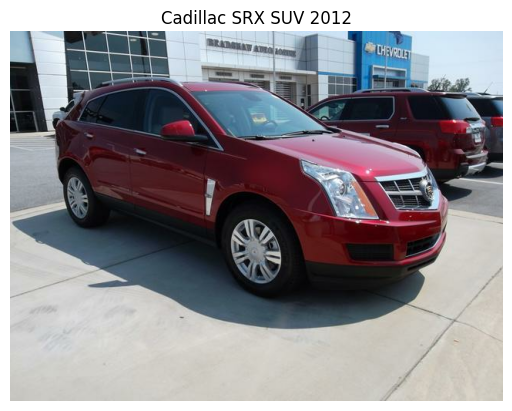

In [19]:
import matplotlib.pyplot as plt
# Obtener una imagen del dataset y graficarla
train_one_sample = train_data.take(1)
train_one_sample
for image, label, in train_one_sample:
    print(f"""
        Image Shape: {image.shape}
        Image Datatype: {image.dtype}
        Target class from cars196: {label}
        class name (str form): {class_names[label.numpy()]}
        """)
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## 2. Crear un pipeline de datos